In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.cluster import KMeans
import copy

import sys
sys.path.append("lib")

import lib

import torch
torch.set_default_dtype(torch.float64)

from functorch import vmap
from torch.utils.data import DataLoader
import tqdm

from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

/home/peiyi/mambaforge3/envs/rom/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda")

In [3]:
coords_x, coords_y, _ = lib.utils.read_coords("mu_0.30/time_step_0.csv")
coords = torch.stack((coords_x, coords_y), dim=1)
N = coords.shape[0]

In [4]:
S = 1501
train_test_split = [0.9, 0.1]

u_30 = lib.utils.read_data(S, N, 'mu_0.30/time_step_', 'vel_0')
u_30_train, u_30_test = lib.utils.split_data(u_30, train_test_split)

In [5]:
u_35 = lib.utils.read_data(S, N, 'mu_0.35/time_step_', 'vel_0')
u_35_train, u_35_test = lib.utils.split_data(u_35, train_test_split)

In [6]:
u_40 = lib.utils.read_data(S, N, 'mu_0.40/time_step_', 'vel_0')
u_40_train, u_40_test = lib.utils.split_data(u_40, train_test_split)

In [7]:
u_45 = lib.utils.read_data(S, N, 'mu_0.45/time_step_', 'vel_0')
u_45_train, u_45_test = lib.utils.split_data(u_45, train_test_split)

In [8]:
train_data = torch.cat([u_30_train, u_35_train, u_40_train, u_45_train])
test_data = torch.cat([u_30_test, u_35_test, u_40_test, u_45_test])

In [9]:
train_norm = torch.sum(train_data**2)
eval_norm = torch.sum(test_data**2)

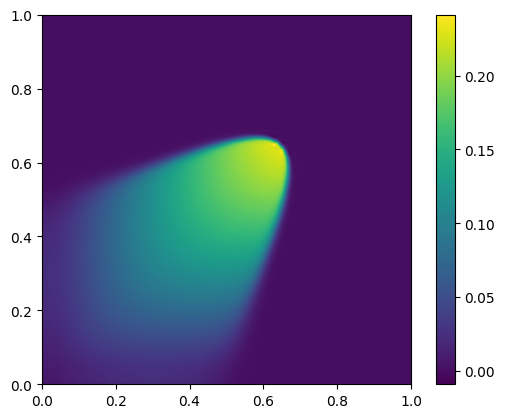

In [10]:
# data coordinates and values
x = coords_x.tolist()
y = coords_y.tolist()
z = u_30[1500].tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,500)
xi,yi = np.meshgrid(xi,yi)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

In [11]:
m = 4000
clustering = KMeans(n_clusters=m, random_state=0, n_init="auto").fit(coords)

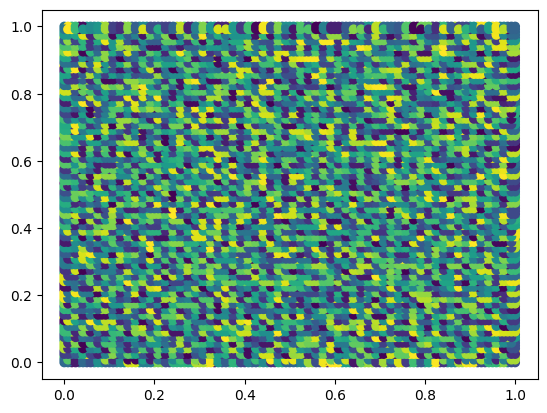

In [12]:
plt.scatter(coords_x, coords_y,c=clustering.labels_)

In [13]:
n = 20
# fixed support (length)
mu = int(np.ceil(N/100))
# mu = N
neighbour_distance, neighbour_id = lib.utils.topk_neighbours(coords, mu)

In [14]:
u_ref = torch.mean(train_data, dim=0)

train_normalized = train_data - u_ref
test_normalized = test_data - u_ref


In [15]:
batch_size = 10
train_normalized = train_normalized.to(device)
test_normalized = test_normalized.to(device)
train_dataloader = DataLoader(train_normalized, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_normalized, batch_size=batch_size, shuffle=True)

In [16]:
ed = lib.nrbs_hot_map.EncoderDecoder(N=N, n=n, mu=mu, m=[200, m], B0=1/60, neighbour_id=neighbour_id, neighbour_distance=neighbour_distance, clustering_labels=torch.tensor(clustering.labels_).type(torch.LongTensor), device=device)

In [17]:
ed.train(train_dataloader, test_dataloader, train_norm, eval_norm, comment="test_hotmap_60_60_200_800_N_200_m_4000_ref_vec_scale_no_proj_err_4_mus", model_name = "models/test_hotmap_60_60_200_800_N_200_m_4000_ref_vec_scale_no_proj_err_4_mus.pth", epochs=1000)

KeyboardInterrupt: 

In [ ]:
ed(u_normalized[500:501])[0].shape

torch.Size([2601])

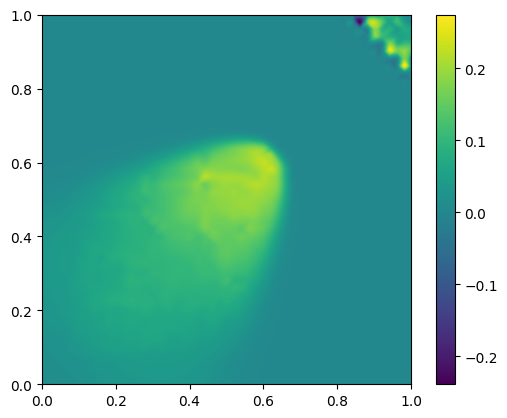

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# data coordinates and values
x = coords_x.tolist()
y = coords_y.tolist()
z = ed(u_normalized[500:501])[0]
# z = (z + (u_max + u_min) / (u_max - u_min)) * (u_max - u_min) / 2
# z = (z + u_min / (u_max - u_min)) * (u_max - u_min)
z = scaler.inverse_transform(z.detach().cpu().reshape(1, -1))
z = z.tolist()
z = z[0]

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

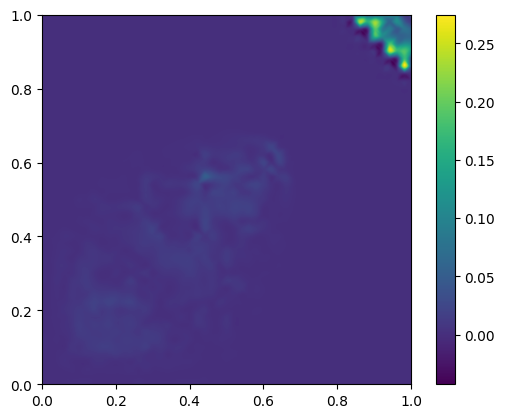

In [ ]:
# label = u[500]
# # label = (label + (u_max + u_min) / (u_max - u_min)) * (u_max - u_min) / 2
# label = (label + u_min / (u_max - u_min)) * (u_max - u_min)

# pred = ed(u[500:501])[0]
# # pred = (pred + (u_max + u_min) / (u_max - u_min)) * (u_max - u_min) / 2
# pred = (pred + u_min / (u_max - u_min)) * (u_max - u_min)

label = u[500].detach().cpu().reshape(1, -1)
pred = ed(u_normalized[500:501])[0]
pred = scaler.inverse_transform(pred.detach().cpu().reshape(1, -1))


z = (abs(label - pred)).tolist()
z = z[0]



# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

In [ ]:
max(z)

0.2678883133591786